# split data

In [ ]:
import shutil
import os
import random

d = "/content/drive/MyDrive/CV/project/data_copy/sample"
new_d = "/content/drive/MyDrive/CV/project/images_small/"
count = 0

for root, dir_name, file_names in os.walk(d):
  for file_name in file_names:
    num = random.random()
    try:
      if num < 0.8:
          shutil.copy(root+"/"+file_name, new_d+"train/train/"+file_name)
      elif num < 0.9:
          shutil.copy(root+"/"+file_name, new_d+"val/val/"+file_name)
      else:
          shutil.copy(root+"/"+file_name, new_d+"test/test/"+file_name)
      count += 1
    except:
      continue
print(count)

11077


# mount drive and import library

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torch.nn.functional as F

import torchvision
from torchvision import transforms, datasets, models
from torchvision.datasets import ImageFolder

from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
from skimage.color import rgb2lab, lab2rgb, rgb2gray
import math

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# helper function

In [4]:
# convert image into Lab colorspace
# use the lightness channel as X and color channels as y
def convertImage(image):
  image = np.asarray(image)
  lab_image = rgb2lab(image)
  lab_image = (lab_image + 128) / 255
  X = np.reshape(rgb2gray(image), (1,256,256))
  y = np.reshape(lab_image[:,:,1:3], (2,256,256))
  return torch.tensor(X), torch.tensor(y)

In [5]:
def train_model(model, loss, optimizer, N_EPOCHS, train_batches, val_batches, model_path):
  train_loss_list = []
  val_loss_list = []
  best_loss = math.inf
  for epoch in range(N_EPOCHS):
    print("=======training Epoch "+str(epoch)+"=========")
    model.train()
    train_loss_per_batch = []
    for idx, (X_train, y_train, _) in enumerate(train_batches):
      X_train, y_train = X_train.to(device), y_train.to(device)
      # Sets the gradients of all optimized torch.Tensor to zero
      optimizer.zero_grad()
      # perform forward propagation
      y_pred = model(X_train.float())
      # compute loss based on predicted and true labels
      train_loss = loss(y_pred.to(torch.float32), y_train.to(torch.float32))
      train_loss_per_batch.append(train_loss.cpu().detach().numpy())
      # perform backward propagation
      train_loss.backward()
      # update the parameters
      optimizer.step()
    # append mean loss of this epoch
    l = sum(train_loss_per_batch)/len(train_loss_per_batch)
    train_loss_list.append(l)
    print("=======training loss is "+str(l)+"=========")

    # save validation loss for each batch
    model.eval()
    val_loss_per_batch = []
    with torch.no_grad():
      for idx, (X_val, y_val, _) in enumerate(val_batches):
        X_val, y_val = X_val.to(device), y_val.to(device)
        # perform forward propagation
        y_pred = model(X_val.float())
        # append loss in this bach
        val_loss_per_batch.append(loss(y_pred.to(torch.float32), y_val.to(torch.float32)).cpu().detach().numpy())
    # append mean loss of this epoch
    l = sum(val_loss_per_batch)/len(val_loss_per_batch)
    val_loss_list.append(l)
    print("=======validation loss is "+str(l)+"=========")
    # save the model if it is the currect best one
    if l < best_loss:
      torch.save(model.state_dict(), model_path)
      best_loss = l
  return train_loss_list, val_loss_list

In [6]:
def plot_train_results(train_loss_list, val_loss_list):
  # plot validation loss and validation accuracy
  plt.plot(train_loss_list, label='train loss')
  plt.xlabel("Number of Epochs")
  plt.ylabel("Train Loss")
  plt.show()

  plt.plot(val_loss_list, label='validation loss')
  plt.xlabel("Number of Epochs")
  plt.ylabel("Validation Loss")
  plt.show()

# load data

In [7]:
class LABImageFolder(datasets.ImageFolder):
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
      img = self.transform(img)
    x, y = convertImage(img)
    if self.target_transform is not None:
      target = self.target_transform(target)
    return x, y, target

In [8]:
# define constant
BATCH_SIZE = 32
d = "/content/drive/MyDrive/CV/project/images_small/"

# load images into DataLoader
# Training
# train_transforms = transforms.Compose([transforms.RandomHorizontalFlip()])
train_imagefolder = LABImageFolder(d+'train')
train_batches = torch.utils.data.DataLoader(train_imagefolder, batch_size=BATCH_SIZE, shuffle=True)

# Validation 
val_imagefolder = LABImageFolder(d+'val')
val_batches = torch.utils.data.DataLoader(val_imagefolder, batch_size=BATCH_SIZE, shuffle=False)

# Test 
test_imagefolder = LABImageFolder(d+'test')
test_batches = torch.utils.data.DataLoader(test_imagefolder, batch_size=BATCH_SIZE, shuffle=False)

# models

## CNN from scratch

In [8]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Sequential(     
      nn.Conv2d(1, 64, kernel_size=(3, 3), padding='same'),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1,1)),
      nn.ReLU(),
      nn.BatchNorm2d(64),
    )
    self.conv2 = nn.Sequential(     
      nn.Conv2d(64, 128, kernel_size=(3, 3), padding='same'),
      nn.ReLU(),
      nn.Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1,1)),
      nn.ReLU(),
      nn.BatchNorm2d(128),
    )
    self.conv3 = nn.Sequential(     
      nn.Conv2d(128, 256, kernel_size=(3, 3), padding='same'),
      nn.ReLU(),
      nn.Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1,1)),
      nn.ReLU(),
      nn.BatchNorm2d(256),
    )
    self.conv4 = nn.Sequential(     
      nn.Conv2d(256, 512, kernel_size=(3, 3), padding='same'),
      nn.ReLU(),
      nn.Conv2d(512, 512, kernel_size=(3, 3), padding='same'),
      nn.ReLU(),
      nn.BatchNorm2d(512),
    )
    self.conv5 = nn.Sequential(     
      nn.Conv2d(512, 512, kernel_size=(3, 3), padding='same'),
      nn.ReLU(),
      nn.Conv2d(512, 512, kernel_size=(3, 3), padding='same'),
      nn.ReLU(),
      nn.BatchNorm2d(512),
    )
    self.conv6 = nn.Sequential(     
      nn.Conv2d(512, 512, kernel_size=(3, 3), padding='same'),
      nn.ReLU(),
      nn.Conv2d(512, 512, kernel_size=(3, 3), padding='same'),
      nn.ReLU(),
      nn.BatchNorm2d(512),
    )
    self.up1 = nn.Upsample(scale_factor=2, mode='bilinear')
    self.conv7 = nn.Sequential(
        nn.Conv2d(512, 256, kernel_size=(3, 3), padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(256),
    )
    self.up2 = nn.Upsample(scale_factor=2, mode='bilinear')
    self.conv8 = nn.Conv2d(256, 2, kernel_size=(3, 3), padding='same')
    self.up3 = nn.Upsample(scale_factor=2, mode='bilinear')
  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.conv6(x)
    x = torch.relu(self.conv7(self.up1(x)))
    x = torch.relu(self.conv8(self.up2(x)))
    return self.up3(x)

In [ ]:
model = Net().float()
model = model.to(device)
loss = nn.MSELoss().to(device) # mse loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0) # use Adam as optimizer

In [ ]:
from torchsummary import summary
summary(model, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 128, 128]          65,600
              ReLU-4         [-1, 64, 128, 128]               0
       BatchNorm2d-5         [-1, 64, 128, 128]             128
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8          [-1, 128, 64, 64]         262,272
              ReLU-9          [-1, 128, 64, 64]               0
      BatchNorm2d-10          [-1, 128, 64, 64]             256
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 32, 32]       1,048,832
             ReLU-14          [-1, 256,

In [ ]:
N_EPOCHS = 10

In [ ]:
train_loss_list, val_loss_list = train_model(model, loss, optimizer, N_EPOCHS, train_batches, val_batches, "/content/drive/MyDrive/CV/project/cnn_model.pth")

In [ ]:
plot_train_results(train_loss_list, val_loss_list)

In [ ]:
# load best model so far
model = Net()
model = model.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/CV/project/cnn_model.pth'))

for idx, (X_test, y_test, _) in enumerate(test_batches):
  y_pred = model(X_test.float())
  for i, y in enumerate(y_pred):
    recover = np.zeros((256, 256, 3))
    origin = np.zeros((256, 256, 3))
    y = np.reshape(y.cpu().detach().numpy(), (256,256,2))
    y_true = np.reshape(y_test[i].cpu().detach().numpy(), (256,256,2))
    recover[:,:,0] = X_test[i].cpu()* 100
    recover[:,:,1:] = y * 255 - 128
    origin[:,:,0] = X_test[i].cpu()* 100
    origin[:,:,1:] = y_true * 255 - 128
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(12, 6))
    ax1.imshow(rgb2gray(lab2rgb(origin)), cmap='gray')
    ax2.imshow(lab2rgb(recover))
    ax3.imshow(lab2rgb(origin))
    plt.savefig('/content/drive/MyDrive/CV/project/cnn_test_results/'+str(idx)+'_'+str(i)+'.png')

## ResNet18 as encoder

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights
class PretrainNet(nn.Module):
  def __init__(self, input_size=128):
    super(PretrainNet, self).__init__()

    # use resnet as encoder
    resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT) 
    # change the size of weights of the input layer to accept single-channel images
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # pass midlevel features to decoder
    self.encoder = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: decoder
    self.cnn1 = nn.Sequential(     
      nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
    )
    self.up1 = nn.Upsample(scale_factor=2)
    self.cnn2 = nn.Sequential(
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
    )
    self.cnn3 = nn.Sequential(
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
    )
    self.up2 = nn.Upsample(scale_factor=2)
    self.cnn4 = nn.Sequential(
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
    )
    self.cnn5 = nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1)
    self.up3 = nn.Upsample(scale_factor=2)

  def forward(self, x):
    x = self.encoder(x)
    x = self.cnn1(x)
    x = self.up1(x)
    x = self.cnn2(x)
    x = self.cnn3(x)
    x = self.up2(x)
    x = self.cnn4(x)
    x = self.cnn5(x)
    x = self.up3(x)
    return x

In [ ]:
model = PretrainNet().float()
model = model.to(device)
loss = nn.L1Loss().to(device) # mse loss
optimizer = torch.optim.Adam(model.parameters(),lr=0.001) # use Adam as optimizer

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
from torchsummary import summary
summary(model, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [ ]:
N_EPOCHS = 20

In [ ]:
train_loss_list, val_loss_list = train_model(model, loss, optimizer, N_EPOCHS, train_batches, val_batches, "/content/drive/MyDrive/CV/project/resnet18_l1_model.pth")

=======training Epoch 0=========
=======training loss is 0.051554308303377844=========
=======validation loss is 0.04378428395305361=========
=======training Epoch 1=========
=======training loss is 0.043796828497539866=========
=======validation loss is 0.04341811750616346=========
=======training Epoch 2=========
=======training loss is 0.04353514217517593=========
=======validation loss is 0.043631209433078764=========
=======training Epoch 3=========
=======training loss is 0.04352788858792998=========
=======validation loss is 0.0444058677979878=========
=======training Epoch 4=========
=======training loss is 0.04325494320555167=========
=======validation loss is 0.043324642309120726=========
=======training Epoch 5=========
=======training loss is 0.043310336511243476=========
=======validation loss is 0.04324839168361255=========
=======training Epoch 6=========
=======training loss is 0.043034148053689436=========
=======validation loss is 0.04345658804689135=========
=======t

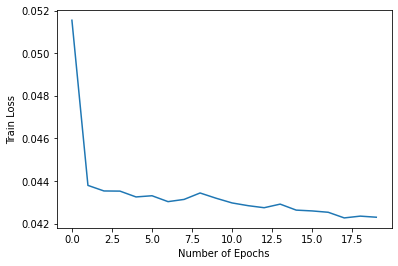

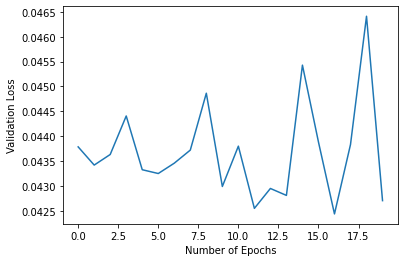

In [ ]:
plot_train_results(train_loss_list, val_loss_list)

In [ ]:
# load best model so far
model = PretrainNet()
model = model#.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/CV/project/resnet18_l1_model.pth'))

for idx, (X_test, y_test, _) in enumerate(test_batches):
      #X_test, y_test = X_test.to(device), y_test.to(device)
      # perform forward propagation
      y_pred = model(X_test.float())
      for i, y in enumerate(y_pred):
        recover = np.zeros((256, 256, 3))
        origin = np.zeros((256, 256, 3))
        y = np.reshape(y.cpu().detach().numpy(), (256,256,2))
        y_true = np.reshape(y_test[i].cpu().detach().numpy(), (256,256,2))
        recover[:,:,0] = X_test[i].cpu()* 100
        recover[:,:,1:] = y * 255 - 128
        origin[:,:,0] = X_test[i].cpu()* 100
        origin[:,:,1:] = y_true * 255 - 128
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(12, 6))
        ax1.imshow(rgb2gray(lab2rgb(origin)), cmap='gray')
        ax2.imshow(lab2rgb(recover))
        ax3.imshow(lab2rgb(origin))
        plt.savefig('/content/drive/MyDrive/CV/project/RESNET_l1_test_results/'+str(idx)+'_'+str(i)+'.png')

## U-Net with ResNet18 Backbone

In [ ]:
!pip install fastai

In [ ]:
from fastai.vision.learner import create_body
from torchvision.models import resnet18, ResNet18_Weights
from fastai.vision.models.unet import DynamicUnet


resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)
resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
resnet = nn.Sequential(*list(resnet.children())[:-2])
model = DynamicUnet(resnet, 2, (256,256), norm_type=None, y_range=[0,1])
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss = nn.L1Loss().to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
from torchsummary import summary
summary(model, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [ ]:
N_EPOCHS = 10

In [ ]:
train_loss_list, val_loss_list = train_model(model, loss, optimizer, N_EPOCHS, train_batches, val_batches, "/content/drive/MyDrive/CV/project/unet_l1_model.pth")

=======training Epoch 0=========
=======training loss is 0.0037691910260102966=========
=======validation loss is 0.0032744999110166516=========
=======training Epoch 1=========
=======training loss is 0.0030635959117419342=========
=======validation loss is 0.0031801774366093534=========
=======training Epoch 2=========
=======training loss is 0.002754964494908398=========
=======validation loss is 0.00301040384386267=========
=======training Epoch 3=========
=======training loss is 0.0024726351714608346=========
=======validation loss is 0.002988910016470722=========
=======training Epoch 4=========
=======training loss is 0.00226733993654224=========
=======validation loss is 0.002927952925009387=========
=======training Epoch 5=========
=======training loss is 0.0021277000437575307=========
=======validation loss is 0.002863480689536248=========
=======training Epoch 6=========
=======training loss is 0.0020317918735302306=========
=======validation loss is 0.002845240051725081====

In [ ]:
# train for more epochs
from fastai.vision.learner import create_body
from torchvision.models import resnet18, ResNet18_Weights
from fastai.vision.models.unet import DynamicUnet

# load best model so far
resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
resnet = nn.Sequential(*list(resnet.children())[:-2])
model = DynamicUnet(resnet, 2, (256,256), norm_type=None, y_range=[0,1])

model = model.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/CV/project/unet_l1_model_30.pth', map_location=torch.device('cpu')))
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
loss = nn.L1Loss().to(device)

train_loss_list, val_loss_list = train_model(model, loss, optimizer, 10, train_batches, val_batches, "/content/drive/MyDrive/CV/project/unet_l1_model_40.pth")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

=======training Epoch 0=========
=======training loss is 0.02183348399671641=========
=======validation loss is 0.03373880077685629=========
=======training Epoch 1=========
=======training loss is 0.021589356830174274=========
=======validation loss is 0.03366397683109556=========
=======training Epoch 2=========
=======training loss is 0.021421202129938387=========
=======validation loss is 0.033669689084802355=========
=======training Epoch 3=========
=======training loss is 0.02130087431181561=========
=======validation loss is 0.033684360874550685=========
=======training Epoch 4=========
=======training loss is 0.021189087703824043=========
=======validation loss is 0.03367855256157262=========
=======training Epoch 5=========


In [ ]:
plot_train_results(train_loss_list, val_loss_list)

In [1]:
from fastai.vision.learner import create_body
from torchvision.models import resnet18, ResNet18_Weights
from fastai.vision.models.unet import DynamicUnet

# load best model so far
resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
resnet = nn.Sequential(*list(resnet.children())[:-2])
model = DynamicUnet(resnet, 2, (256,256), norm_type=None, y_range=[0,1])

model = model#.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/CV/project/unet_l1_model_40.pth', map_location=torch.device('cpu')))

for idx, (X_test, y_test, _) in enumerate(val_batches):
      #X_test, y_test = X_test.to(device), y_test.to(device)
      # perform forward propagation
      y_pred = model(X_test.float())
      for i, y in enumerate(y_pred):
        recover = np.zeros((256, 256, 3))
        origin = np.zeros((256, 256, 3))
        y = np.reshape(y.cpu().detach().numpy(), (256,256,2))
        y_true = np.reshape(y_test[i].cpu().detach().numpy(), (256,256,2))
        recover[:,:,0] = X_test[i].cpu()* 100
        recover[:,:,1:] = y * 255 - 128
        origin[:,:,0] = X_test[i].cpu()* 100
        origin[:,:,1:] = y_true * 255 - 128
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(12, 6))
        ax1.imshow(rgb2gray(lab2rgb(origin)), cmap='gray')
        ax2.imshow(lab2rgb(recover))
        ax3.imshow(lab2rgb(origin))
        plt.savefig('/content/drive/MyDrive/CV/project/Unet_l1_test_results/1_'+str(idx)+'_'+str(i)+'.png')
        plt.close()

## U-Net with ResNet34 Backbone

In [ ]:
!pip install fastai

In [ ]:
from fastai.vision.learner import create_body
from torchvision.models import resnet34, ResNet34_Weights
from fastai.vision.models.unet import DynamicUnet


resnet = models.resnet34(weights=ResNet34_Weights.DEFAULT)
resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
resnet = nn.Sequential(*list(resnet.children())[:-2])
model = DynamicUnet(resnet, 2, (256,256), norm_type=None, y_range=[0,1])
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss = nn.MSELoss().to(device)

In [ ]:
N_EPOCHS = 10

In [ ]:
train_loss_list, val_loss_list = train_model(model, loss, optimizer, N_EPOCHS, train_batches, val_batches, "/content/drive/MyDrive/CV/project/unet34_l2_model_10.pth")

=======training Epoch 0=========
=======training loss is 0.00381525863639333=========
=======validation loss is 0.0032243612554988693=========
=======training Epoch 1=========
=======training loss is 0.003091129767285152=========
=======validation loss is 0.0030599587530429876=========
=======training Epoch 2=========
=======training loss is 0.0028033372260291467=========
=======validation loss is 0.0031621946221483607=========
=======training Epoch 3=========
=======training loss is 0.0025620997726747935=========
=======validation loss is 0.002993137655513627=========
=======training Epoch 4=========
=======training loss is 0.0023256905952637845=========
=======validation loss is 0.002906697768984096=========
=======training Epoch 5=========


In [ ]:
plot_train_results(train_loss_list, val_loss_list)

In [2]:
from fastai.vision.learner import create_body
from torchvision.models import resnet34, ResNet34_Weights
from fastai.vision.models.unet import DynamicUnet

# load best model so far
resnet = resnet34(weights=ResNet34_Weights.DEFAULT)
resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
resnet = nn.Sequential(*list(resnet.children())[:-2])
model = DynamicUnet(resnet, 2, (256,256), norm_type=None, y_range=[0,1])

model = model#.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/CV/project/unet34_l2_model.pth', map_location=torch.device('cpu')))

for idx, (X_test, y_test, _) in enumerate(test_batches):
      #X_test, y_test = X_test.to(device), y_test.to(device)
      # perform forward propagation
      y_pred = model(X_test.float())
      for i, y in enumerate(y_pred):
        recover = np.zeros((256, 256, 3))
        origin = np.zeros((256, 256, 3))
        y = np.reshape(y.cpu().detach().numpy(), (256,256,2))
        y_true = np.reshape(y_test[i].cpu().detach().numpy(), (256,256,2))
        recover[:,:,0] = X_test[i].cpu()* 100
        recover[:,:,1:] = y * 255 - 128
        origin[:,:,0] = X_test[i].cpu()* 100
        origin[:,:,1:] = y_true * 255 - 128
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(12, 6))
        ax1.imshow(rgb2gray(lab2rgb(origin)), cmap='gray')
        ax2.imshow(lab2rgb(recover))
        ax3.imshow(lab2rgb(origin))
        plt.savefig('/content/drive/MyDrive/CV/project/Unet34_l2_test_results/'+str(idx)+'_'+str(i)+'.png')
        plt.close()